In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv
/kaggle/input/new-york-city-airbnb-open-data/New_York_City_.png


In [2]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex5 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings

import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from statsmodels.tsa.deterministic import DeterministicProcess
from xgboost import XGBRegressor


Exploratory Data Analysis

In [3]:
df = pd.read_csv('/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
df.head(10)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [5]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Feature Engineering

In [6]:
#Removing Outliers
min_price = 0
max_price = 1000
df1 = df[(df.price<max_price) & (df.price>min_price)]
df1.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.858600e+04,4.858600e+04,48586.000000,48586.000000,48586.000000,48586.000000,48586.000000,38696.000000,48586.000000,48586.000000
mean,1.902135e+07,6.763733e+07,40.728927,-73.952031,140.269049,6.974931,23.372803,1.375256,7.168670,112.365928
std,1.097890e+07,7.860718e+07,0.054580,0.046156,112.899316,20.276877,44.651661,1.681915,33.046098,131.383634
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,10.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.476410e+06,7.831209e+06,40.690002,-73.982950,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967620e+07,3.084879e+07,40.722960,-73.955580,105.000000,3.000000,5.000000,0.720000,1.000000,44.000000
75%,2.914903e+07,1.074344e+08,40.763130,-73.936100,175.000000,5.000000,24.000000,2.020000,2.000000,225.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,999.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


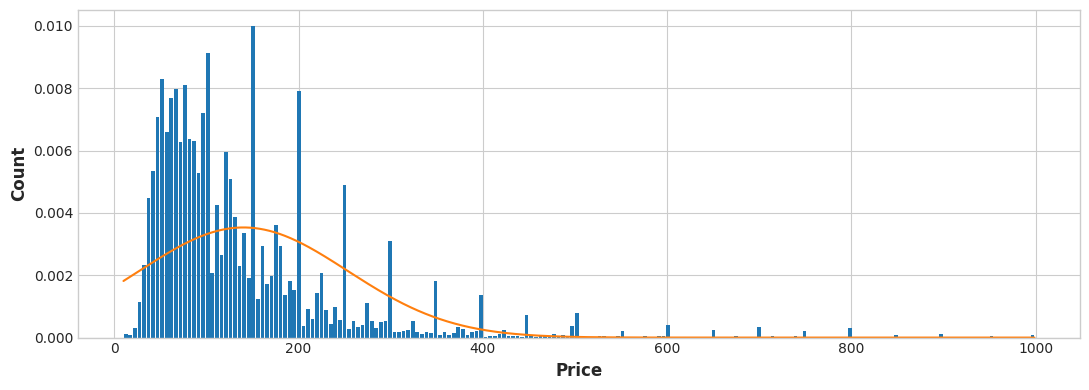

In [7]:
plt.hist(df1.price, bins = 200, rwidth = 0.8, density = True)
plt.xlabel('Price')
plt.ylabel('Count')

rng = np.arange(df1.price.min(), df1.price.max(), 0.3)
plt.plot(rng, norm.pdf(rng, df1.price.mean(), df1.price.std()))

In [8]:
max_nights, min_nights = df.minimum_nights.quantile([0.9995, 0.01])
max_nights, min_nights

(365.0, 1.0)

In [9]:
#Filling Missing Values
df1.fillna({'name' : 'NoName', 'host_name' : 'NoName', 'reviews_per_month' : 0, 'last_review' : 'NotReviewed'}, inplace = True)

In [10]:
#Data After Preprocessing
df2 = df1
df2.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NotReviewed,0.00,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [11]:
#Dropping Unnecessary Features
df2.drop(['latitude', 'longitude', 'host_name','name','id', 'last_review'], axis = 1, inplace = True)
df2.columns

Index(['host_id', 'neighbourhood_group', 'neighbourhood', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365'],
      dtype='object')

Converting categorical columns into numerical using pd.get_dummies

In [12]:
categorical_columns = ['neighbourhood_group', 'neighbourhood', 'room_type']
df3 = pd.get_dummies(df2, columns=['neighbourhood_group', 'neighbourhood', 'room_type'], 
                                prefix=['ng', 'nh', 'rt'], drop_first=True)

X = df3.drop(['price'], axis = 1)
y = df3['price']

Importing Machine Learning Library

In [13]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split 
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

#Splitting Train and Test Data
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Linear Regression

In [14]:
#Fit Linear Regression Model
model1 = LinearRegression()
linearmodel = model1.fit(X_train,y_train)

# Calculate R-squared value
train_X = linearmodel.score(X_train, y_train)

# Predict using the model
y_train_pred = linearmodel.predict(X_train)
y_lineartest_pred = linearmodel.predict(X_test)

# Calculate RMSE
rmse_train_linear = np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))
rmse_test_linear = np.sqrt(metrics.mean_squared_error(y_test, y_lineartest_pred))

rmse_train_linear, rmse_test_linear #Linear Regression Accuracy

(88.94139658682548, 90.42635321899304)

Lasso

In [15]:
#Fit Lasso Model
model2 = Lasso()
lasso = model2.fit(X_train,y_train)

# Calculate R-squared value
lasso_train_X = lasso.score(X_train, y_train)

# Predict using the model
lasso_y_train = linearmodel.predict(X_train)
lasso_y_pred = lasso.predict(X_test)

# Calculate RMSE
rmse_train_lasso = np.sqrt(metrics.mean_squared_error(y_train, lasso_y_train))
rmse_test_lasso = np.sqrt(metrics.mean_squared_error(y_test, lasso_y_pred))


rmse_train_lasso, rmse_test_lasso #Lasso Accuracy

(88.94139658682548, 93.57044788926675)

Random Forest Regression

In [16]:
# Fit Random Forest Regression model
random_forest_model = RandomForestRegressor(n_estimators=100)
random_forest_model.fit(X_train, y_train)

# Calculate R-squared for Random Forest model
r_squared_rf = random_forest_model.score(X_train, y_train)

# Predict using Random Forest model
rf_y_train = random_forest_model.predict(X_train)
rf_y_test = random_forest_model.predict(X_test)

# Calculate RMSE for Random Forest model
rmse_train_rf = np.sqrt(metrics.mean_squared_error(y_train, rf_y_train))
rmse_test_rf = np.sqrt(metrics.mean_squared_error(y_test, rf_y_test))

rmse_train_rf, rmse_test_rf #Random Forest Accuracy

(32.30019313183708, 86.1608963120414)